# Mesenchymal lineage - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)


luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')


colors = c(luz_colors, '#db7293', 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.4        Seurat_3.2.2      

loaded via

In [52]:
markers = list( mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                gonadal = c('ARX', 'GATA4', 'LHX9'),
                extragonadal = c('GATA2', 'NR2F1'),
                somatic_progenitor = c('WT1', 'NR5A1'),
                steroidogenic = c('CYP11A1', 'CYP17A1', 'FDXR', 'MGARP'),
                FetalLeydig = c('INSL3', 'GLI1', 'HHIP', 'PTCH2', 'PTCH1', 'FDX1'),
                gonad_interstitial=c('STAR', 'SIGLEC11', 'NSG1', 'MSC',  'MMP11', 'SPRR2F'),
                gonad_border_mesenhyme = c('FGL2', 'PCSK2', 'ANGPTL1'),
                MullerianDuct_mesen = c('ANKFN1', 'ITGBL1', 'LGR5', 'ISLR2', 'FZD10', 'SCUBE2', 'AMHR2'),
                mesoneprhic_mesen = c('MGP', 'RSPO3', 'CRABP1', 'ISL1', 'BMP4', 'ALX1', 'HOXA9'),
                mesothelial = c('LRRN4', 'UPK3B', 'KLK11'),
                supporting = c('WNT6', 'WIPF3'),
                preGranulosa = c("KITLG", 'OSR1' , 'FOXL2', 'IRX3'),
                sertoli = c('SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3', 'CITED1', 'SERPINA5'),
                epithelial = c("EPCAM"),
                PGCs= c('POU5F1', 'NANOG', 'NANOS3'),
                GCs = c('DAZL', 'DDX4'),
                immunePGCs= c('PTPRC'),
                endothelial = c('PECAM1', 'VWF', 'CDH5'),
                erythroid = c("GYPC", "HBA1"),
                neural = c('ASCL1', 'ELAVL4'),
                PV = c("PDGFRB", 'ACTA2'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [5]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)

In [6]:
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [7]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Mesenchymal_LHX9_ARX', 'Mesenchymal_GATA2_NR2F1')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
# anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata

An object of class Seurat 
28230 features across 129311 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [8]:
table(anndata@meta.data$clusters)


Mesenchymal_GATA2_NR2F1    Mesenchymal_LHX9_ARX 
                  77319                   51992 

In [9]:
# Add SEX metadata
meta_f = read.csv('figures-stromal/annotation_withdoublets.csv', stringsAsFactors = F)


anndata@meta.data$clusters_previous = 'new'
anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_f$X ] = 
meta_f$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_f$X], meta_f$X) ]
table(anndata@meta.data$clusters_previous)

# Remove lowQC and doublets
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, ! clusters_previous %in% c( 'doublet',  'lowQC' ) )))

table(anndata@meta.data$clusters_previous)


    doublet FetalLeydig          Gi       lowQC      M_ALX1      M_BMP4 
       1040        2340       14027        8540        4409        5102 
  M_cycling       M_MGP MullDuctFib         new          Oi          Ti 
      16509       26559       10108        3559       12296       24822 


FetalLeydig          Gi      M_ALX1      M_BMP4   M_cycling       M_MGP 
       2340       14027        4409        5102       16509       26559 
MullDuctFib         new          Oi          Ti 
      10108        3559       12296       24822 

In [10]:
# basic gene/cell filtering
message('Removing ', sum(anndata@meta.data$nCount_RNA < 1000), ' cells with less than 1000 nCount_RNA' )
anndata <- subset(anndata, cells = colnames(anndata)[ anndata@meta.data$nCount_RNA >= 1000 ] )
                 
gene_counts = tabulate(anndata@assays$RNA@counts@i + 1)
message('Removing ', sum(gene_counts <= 5), ' genes expressed in 5 or less cells' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 5 ] )

Removing 3559 cells with less than 1000 nCount_RNA

Removing 4796 genes expressed in 5 or less cells



In [11]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
28230 features across 116172 samples within 1 assay 
Active assay: RNA (28230 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TOP2A, NUSAP1, UBE2C, MKI67, CDK1, TPX2, CENPF, CDCA3, BIRC5, AURKB 
	   CKAP2L, NUF2, GTSE1, CDC20, CDCA8, TACC3, CCNB2, KIF23, NDC80, KIF2C 
	   DLGAP5, CENPA, CDCA2, HJURP, CENPE, SMC4, HMGB2, CKS2, NEK2, KIF11 
Negative:  UNG, TIPIN, RAD51, MCM6, POLA1, CASP8AP2, MSH2, UBR7, SLBP, DSCC1 
	   RPA2, CDCA7, CHAF1B, CTCF, MCM5, RFC2, PRIM1, NASP, WDR76, LBR 
	   CCNE2, MCM4, MCM2, POLD3, CBX

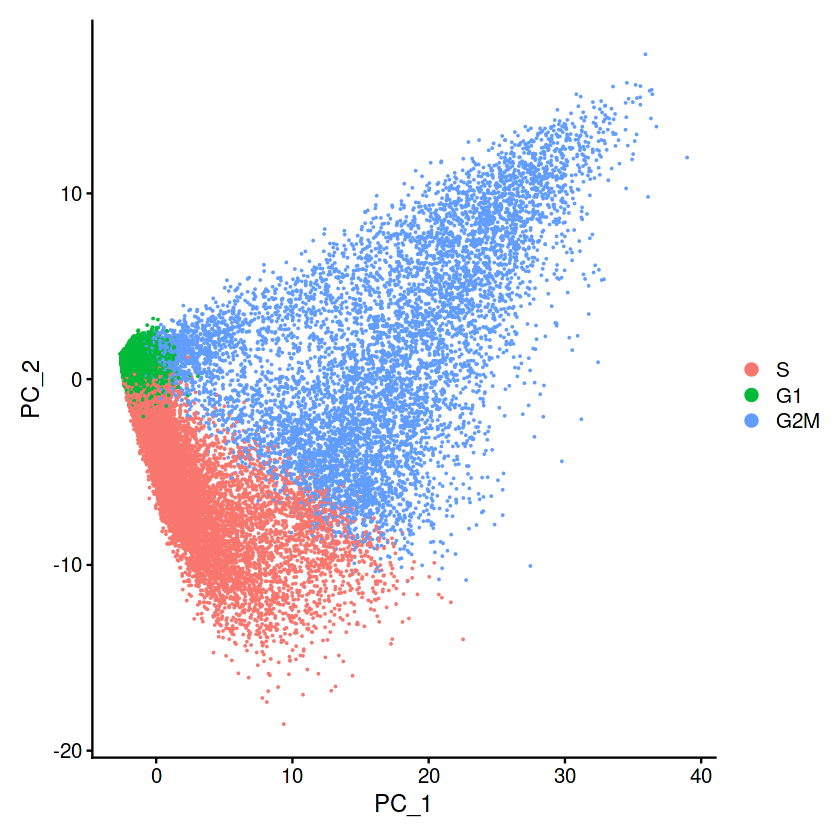

In [12]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [13]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  TOP2A, NUSAP1, UBE2C, CDK1, MKI67, TPX2, CENPF, CCNA2, CDCA3, KIF20A 
	   KIFC1, AURKB, BIRC5, MXD3, CKAP2L, PTTG1, MAD2L1, UBE2T, NUF2, GTSE1 
	   SPC25, TACC3, PIMREG, ASPM, NDC80, KIF23, CDCA8, CDC20, CCNB2, NCAPG 
Negative:  HSPB6, PPP1R14A, RPL26, DLK1, RPS4Y1, OGN, SPARCL1, LHX9, IGF2-1, DCN 
	   RPL17, PLAC9, C4orf48, RNASE1, C7, STAR, RPL41, MSMO1, TIMP1, SPON2 
	   COL1A2, COL1A1, ASPN, MSC, PTCH2, ENG, SPARC, LHFPL6, BST2, EPHX1 
PC_ 2 
Positive:  RNASE1, PPP1R14A, RPS4Y1, STAR, LHX9, DLK1, GATA4, MSC, GSTA1, PLAC1 
	   PTCH2, HMGCS1, MSMO1, WFDC1, EGFLAM, APOA1, DHCR24, NEFL, FDXR, COL15A1 
	   MIR202HG, COLEC11, C4orf48, SQLE, INSL3, NR5A1, SERPINA5, FDFT1, ENC1, PEG3 
Negative:  FBLN1, CPE, SULT1E1, PLAT, GATA2, COL3A1, PCOLCE, PAMR1, ITM2A, NR2F1 
	   AKAP12, FHL1, IGFBP5, COL1A1, TMSB4X, KLHL13, MEST, APCDD1, SPARC, EFEMP1 
	   TBX3, POSTN, MGP, RSPO3, EDNRA, COL6A3, HOXA3, ID2, EFNB2, PRRX1 
PC_ 3 
Positive:  HMGA2, CRABP1, KCNQ2, TNC, GAPDH, KRT18, SF

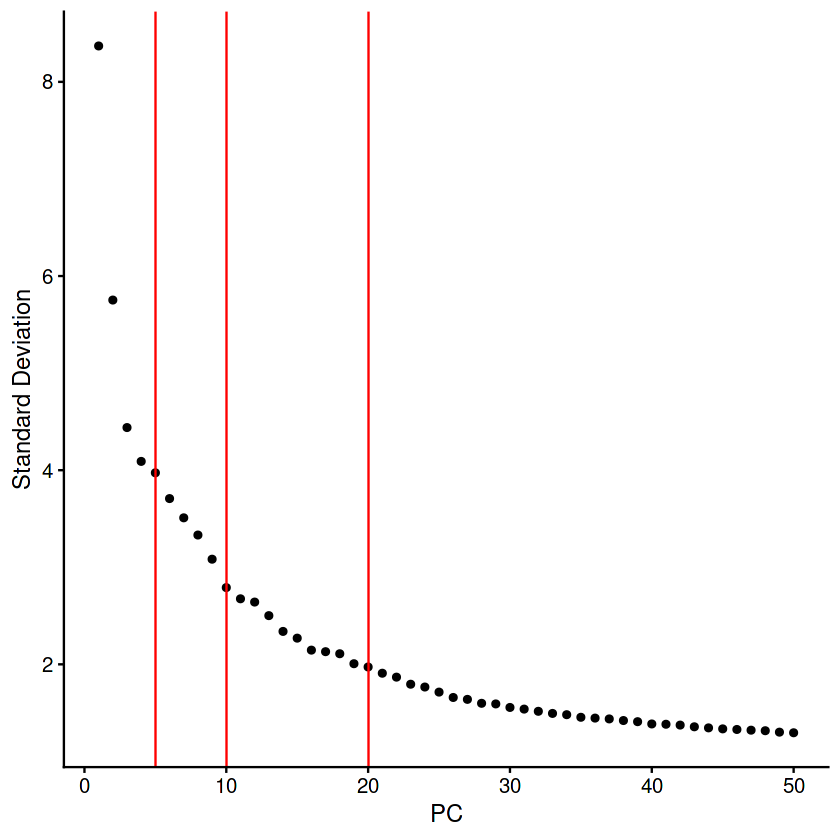

In [14]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [15]:
npca = 15
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0)

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [16]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [17]:
anndata <- FindClusters(anndata, resolution = 0.6)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 116172
Number of edges: 3131670

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8938
Number of communities: 13
Elapsed time: 49 seconds


In [18]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



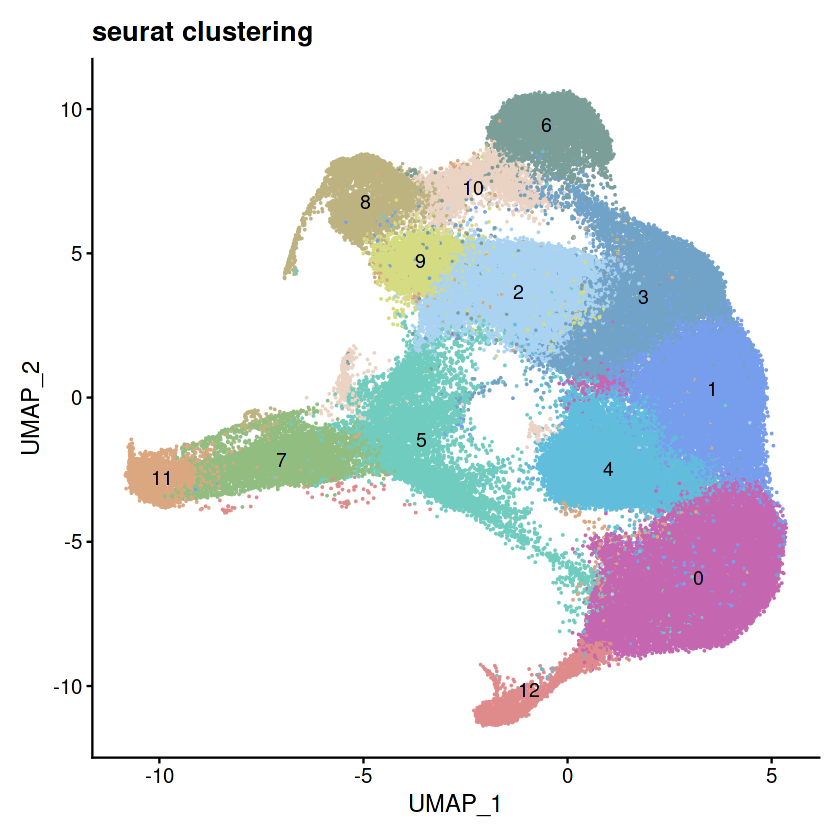

In [19]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-stromal/clean_umap_clustering.pdf'), dpi = 75)

In [20]:
# fix metadata
# Add metadata
meta_f = read.csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/mesenchymalPV_annotated.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_Sex = 'new'

anndata@meta.data$clusters_Sex[ rownames(anndata@meta.data) %in% meta_f$X ] = 
meta_f$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_f$X], meta_f$X) ]


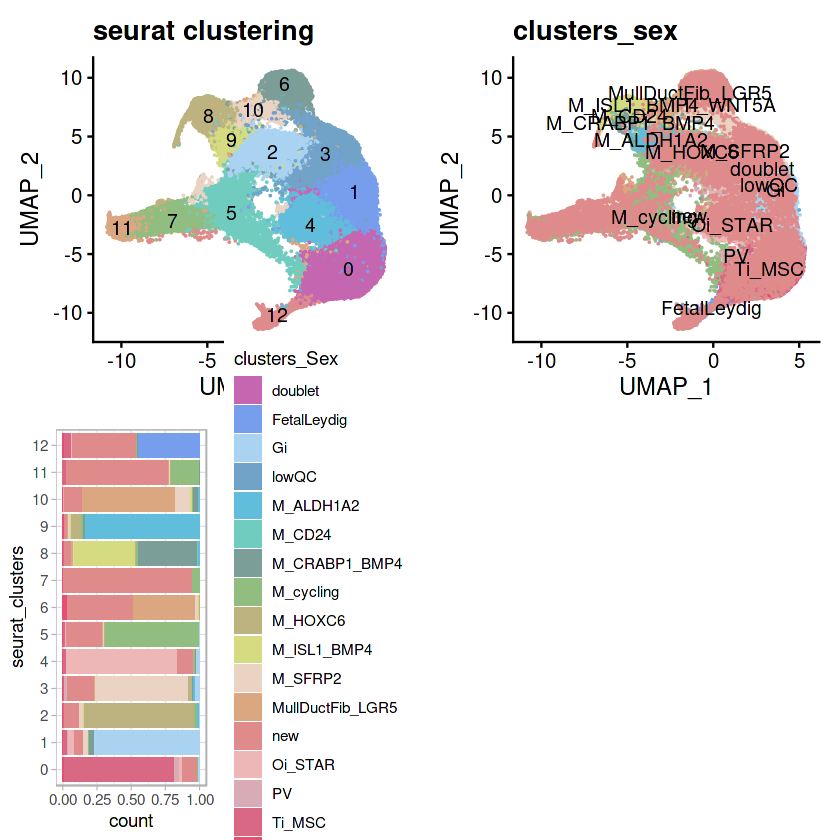

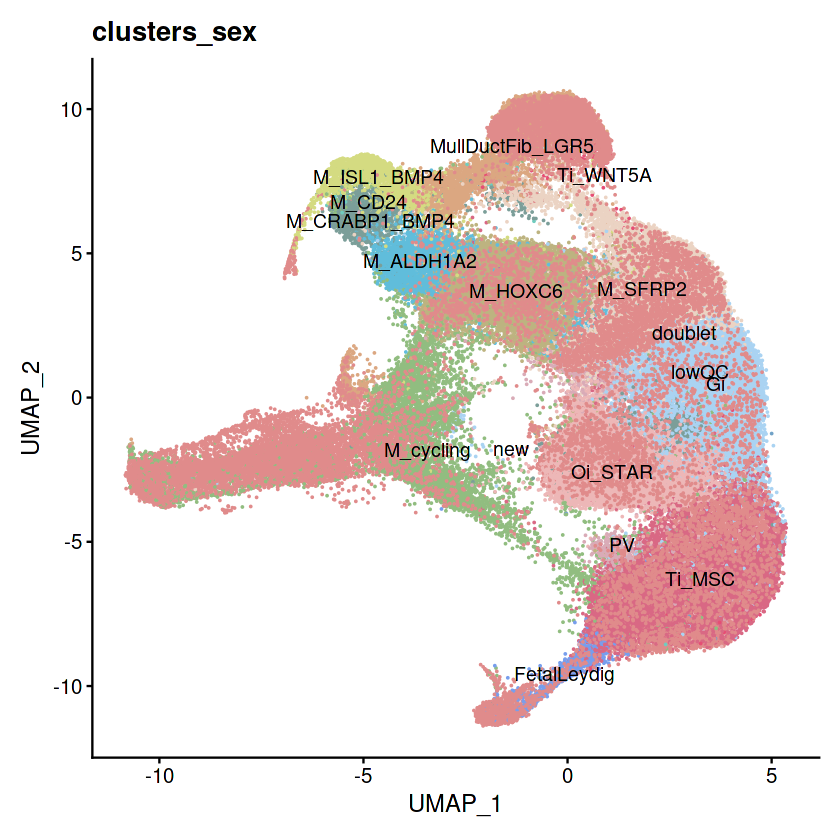

In [21]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_Sex', label = T, cols = colors) + ggtitle('clusters_sex') + NoLegend()
b1 = ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = clusters_Sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
plot_grid(p1, p1b, b1, ncol = 2)
ggsave(filename = paste0('figures-stromal/clean_umap_fromStromal.pdf'), width = 15, height = 15)

p1b

Saving 13.3 x 13.3 in image



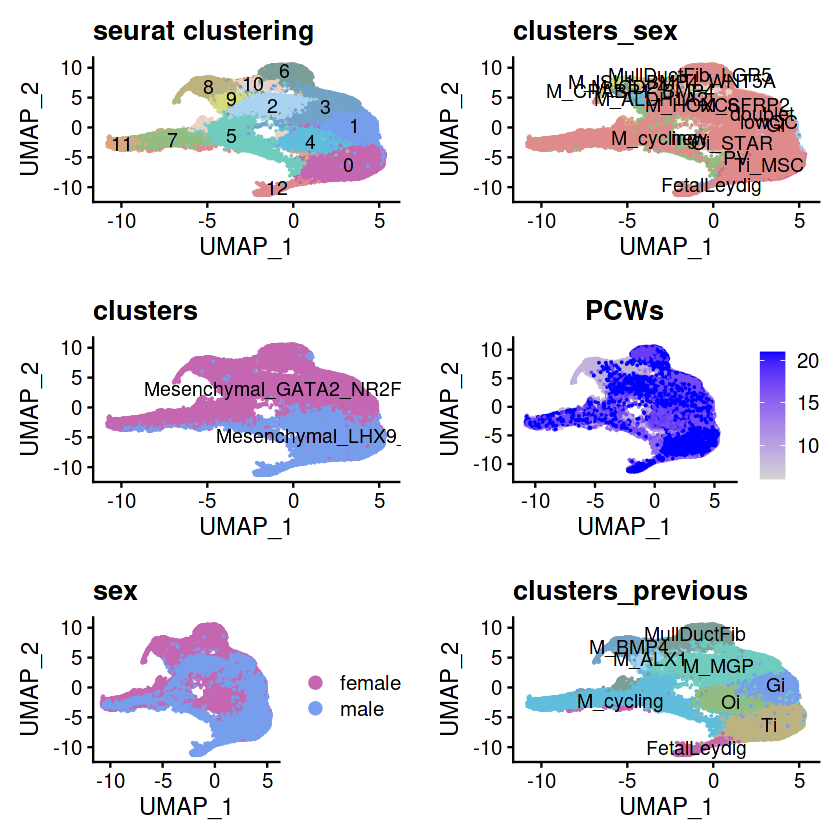

In [37]:
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T, cols = colors) + ggtitle('clusters')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'sex', cols = colors) + ggtitle('sex')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'clusters_previous', label = T,  cols = colors) + ggtitle('clusters_previous') 
plot_grid(p1, p1b, p2+NoLegend(), p3, p4, p5+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-stromal/clean_umap_metadata.pdf'), scale = 2, dpi = 75)

In [23]:
# FeaturePlot(anndataO, features = c(markers, 'MKI67'), ncol = 4)
# ggsave(filename = paste0('figures-stromal/clean_umap_markers.pdf'), width = 10, height = 20, dpi = 75)

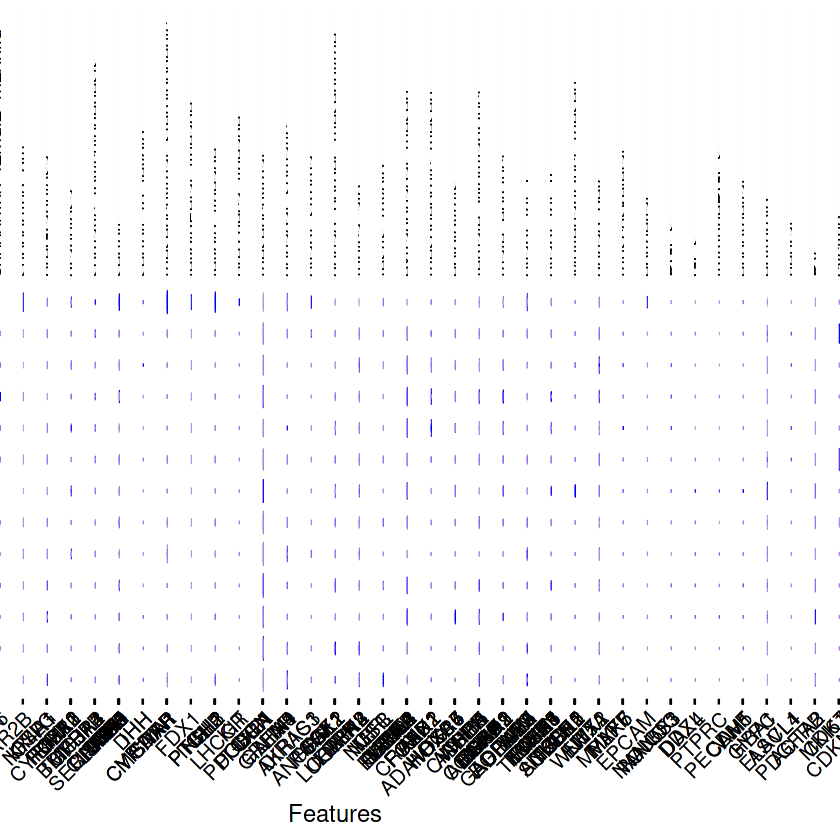

In [24]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-stromal/clean_dotplot_markers.pdf'), dpi = 75, height = 7, width = 35)

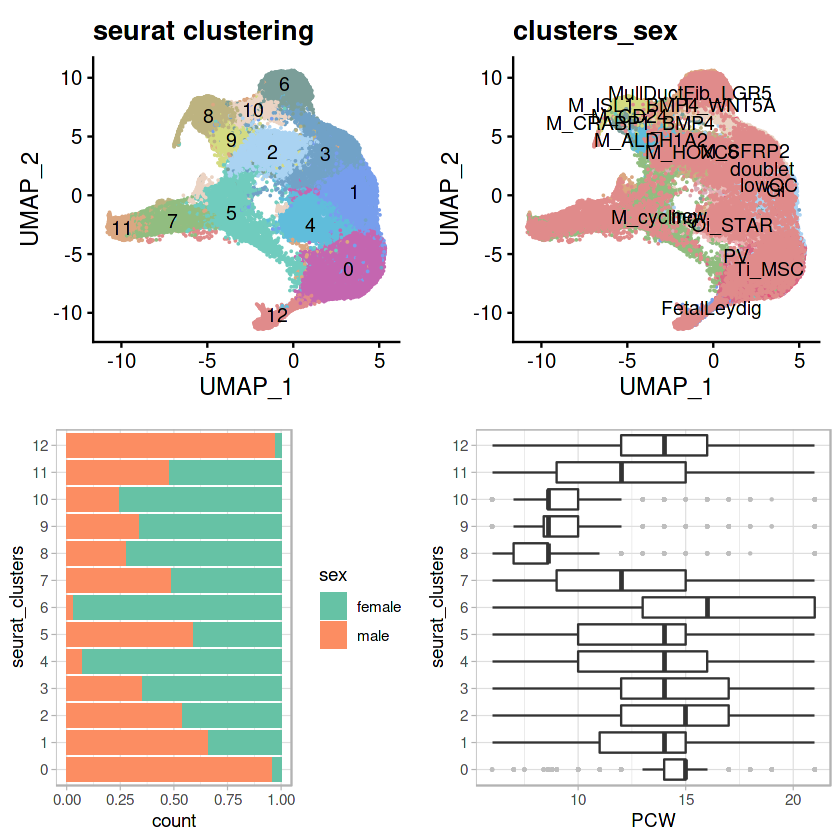

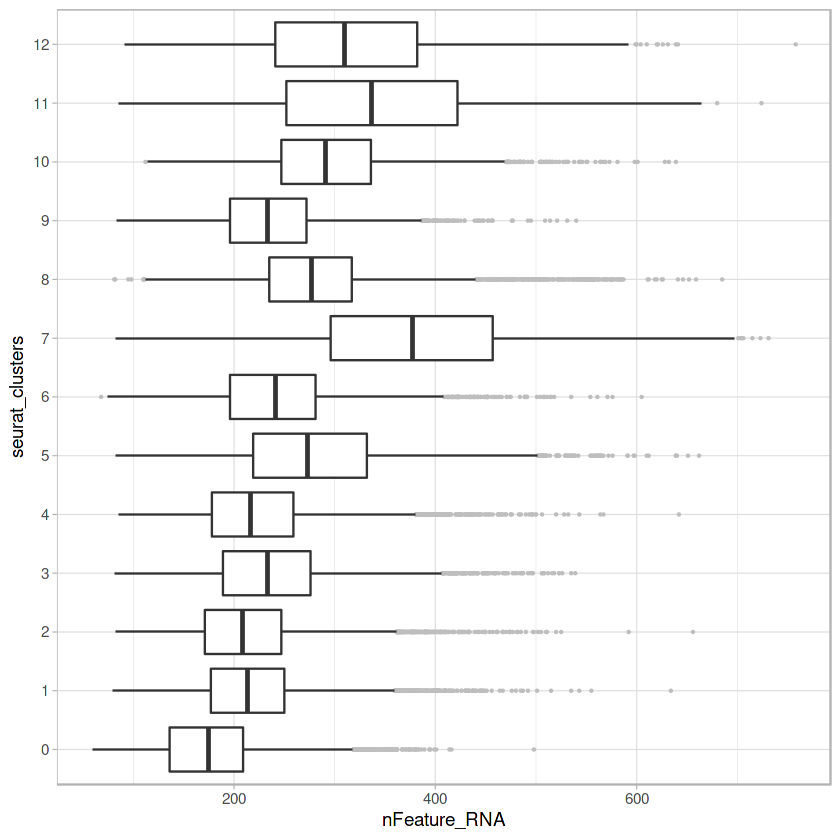

In [25]:
b1 = ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_brewer(palette = 'Set2') + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1, p1b+ NoLegend(), b1, b2, ncol = 2)
ggsave(filename = paste0('figures-stromal/clean_metadata.pdf'), dpi = 75, width = 10, height = 10)


ggplot(anndata@meta.data, aes(x = seurat_clusters, y = nFeature_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()

In [26]:
#save
# saveRDS(anndata, file = 'figures-stromal/clean_seurat.rds')

### DEGs and GSA

In [27]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 50)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-stromal/clean_cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 650  10

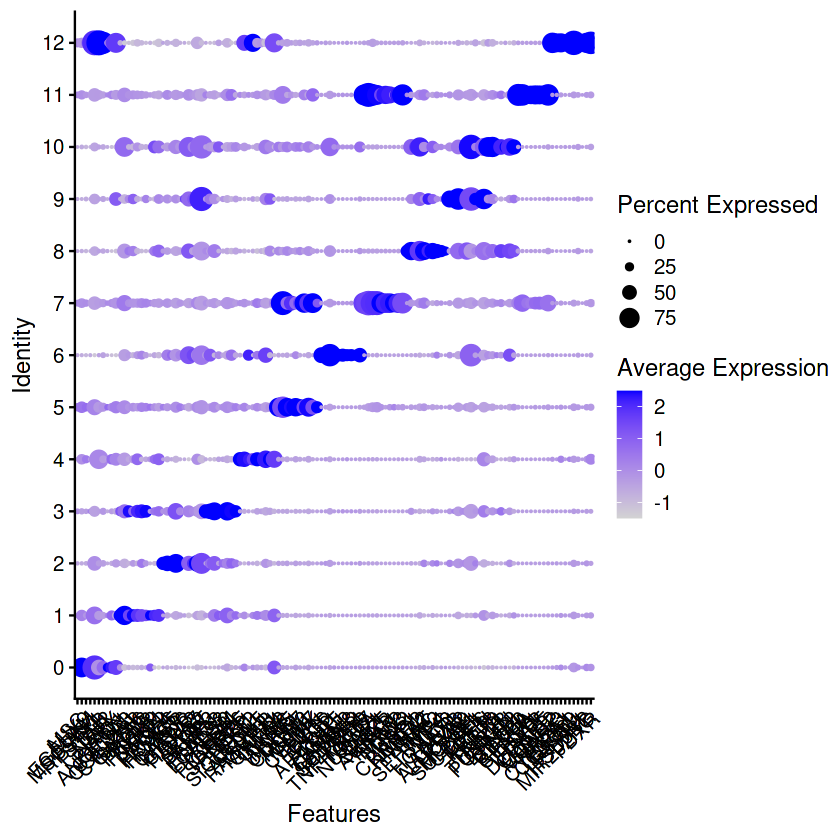

In [28]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGstfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 10L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGstfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-stromal/clean_dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 7, width = 45)

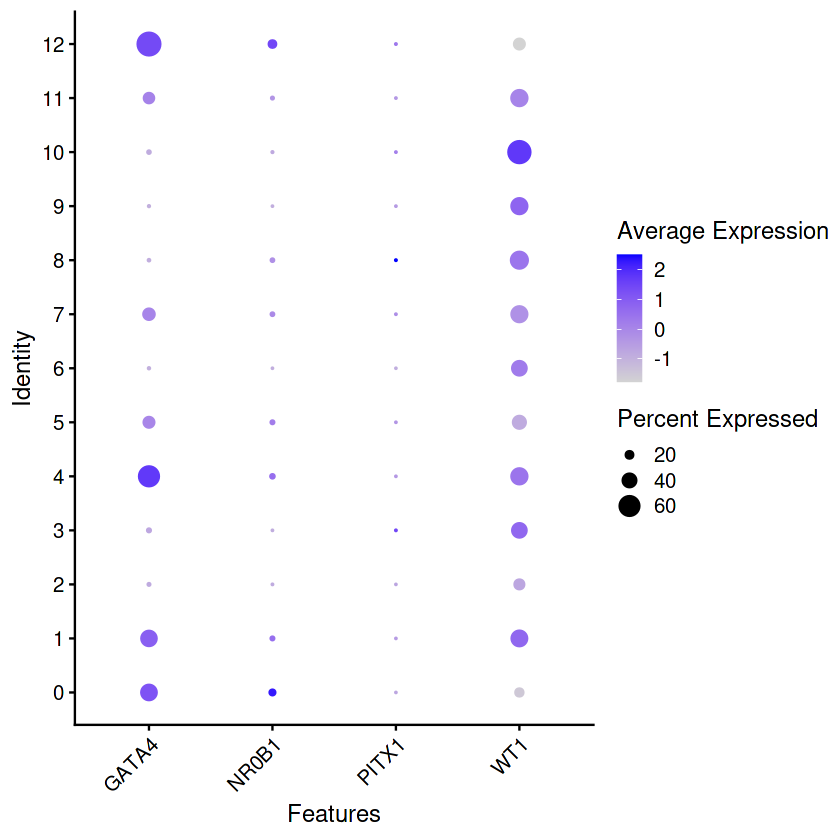

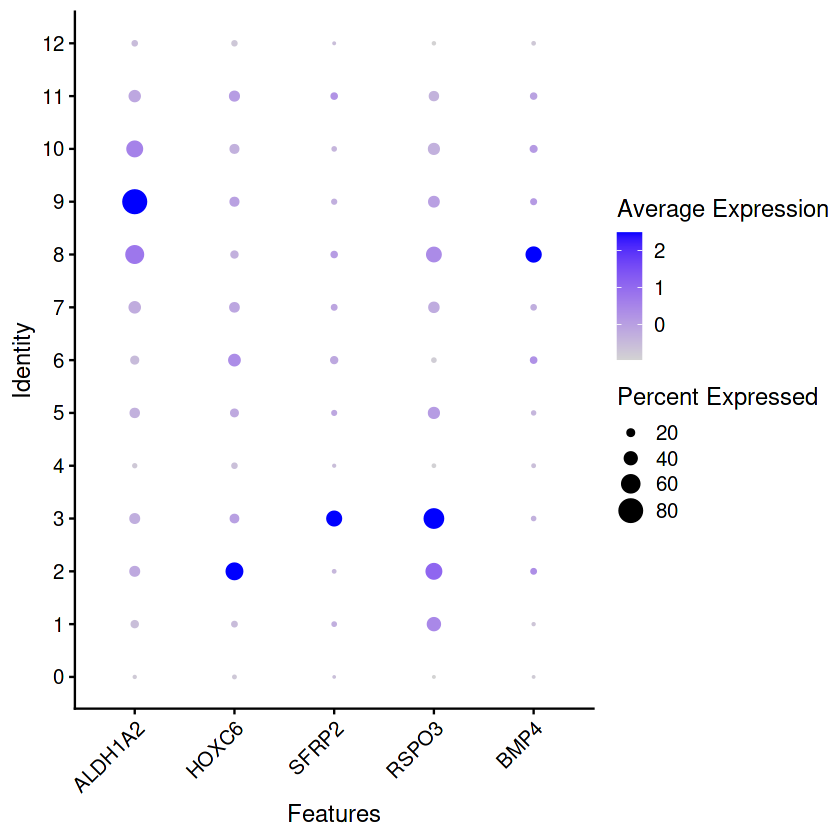

In [29]:
DotPlot(anndataO, features = c('GATA4', 'NR0B1', 'PITX1', 'WT1')) + RotatedAxis() 
DotPlot(anndataO, features = c('ALDH1A2', 'HOXC6', 'SFRP2', 'RSPO3', 'BMP4')) + RotatedAxis() 

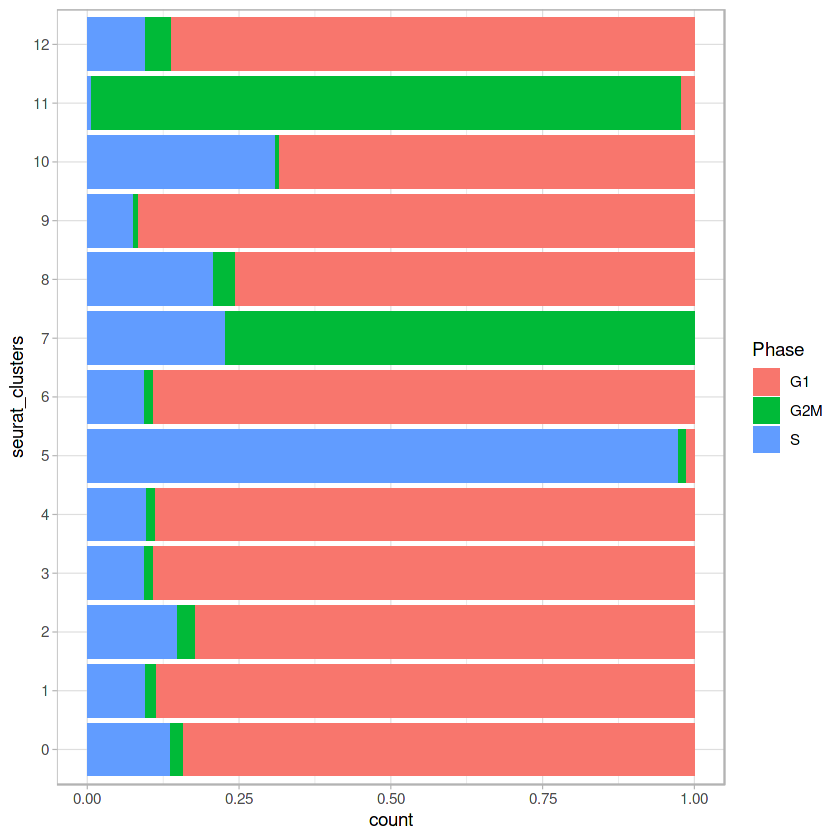

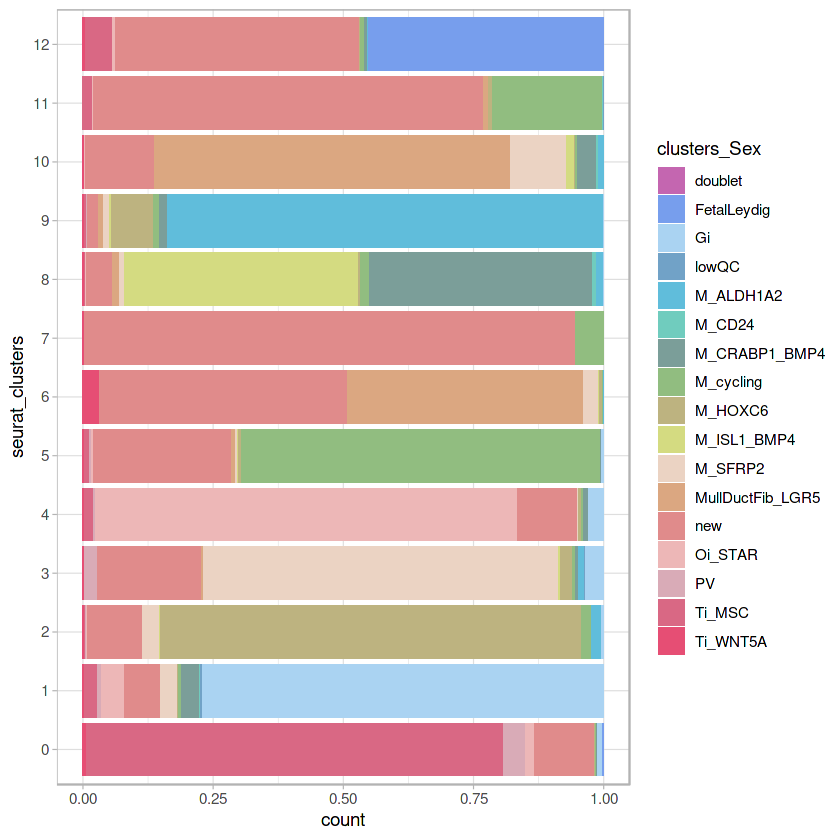

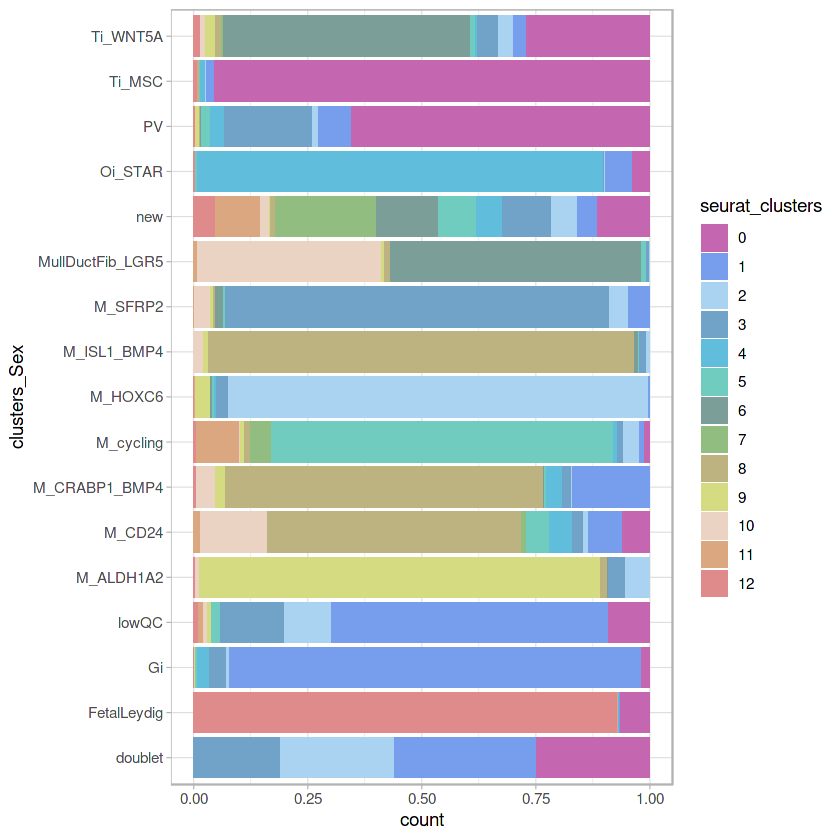

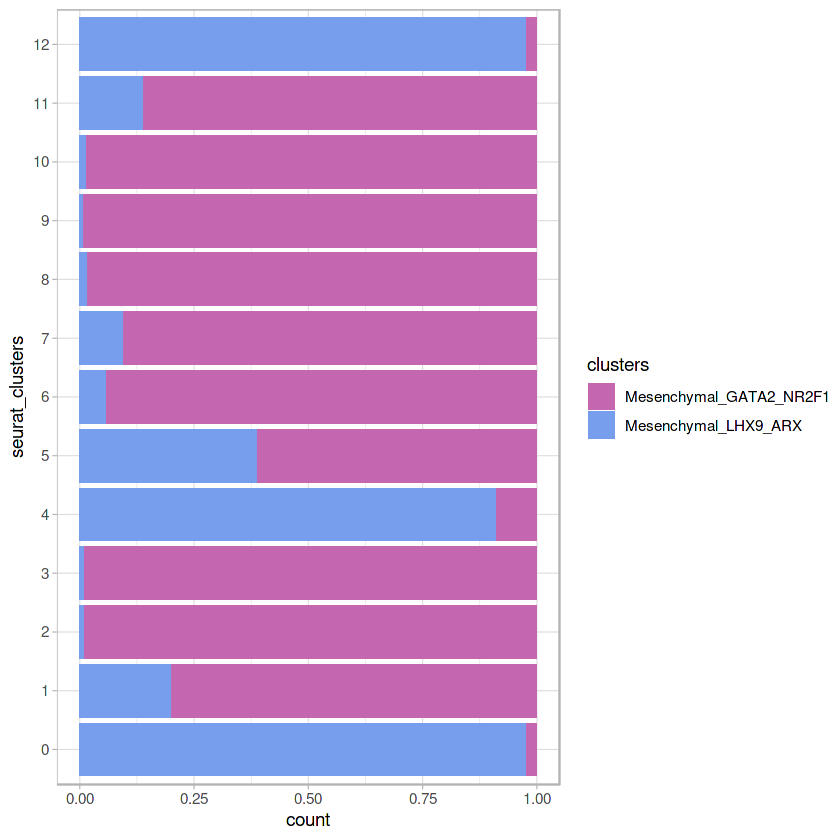

In [30]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = clusters_Sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndata@meta.data, aes(x = clusters_Sex , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters  , fill = clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

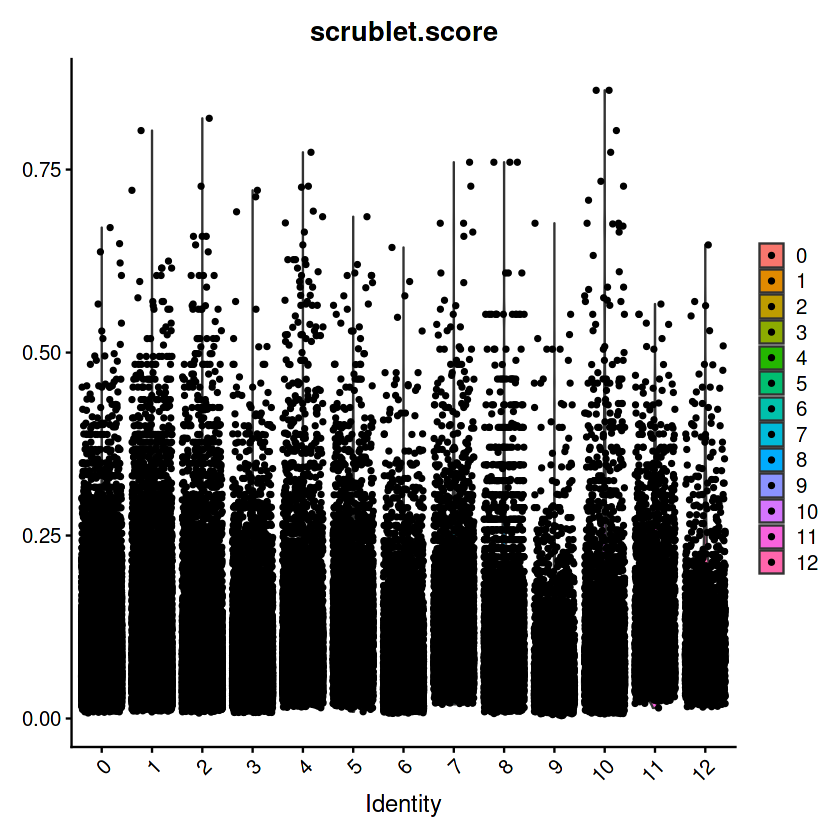

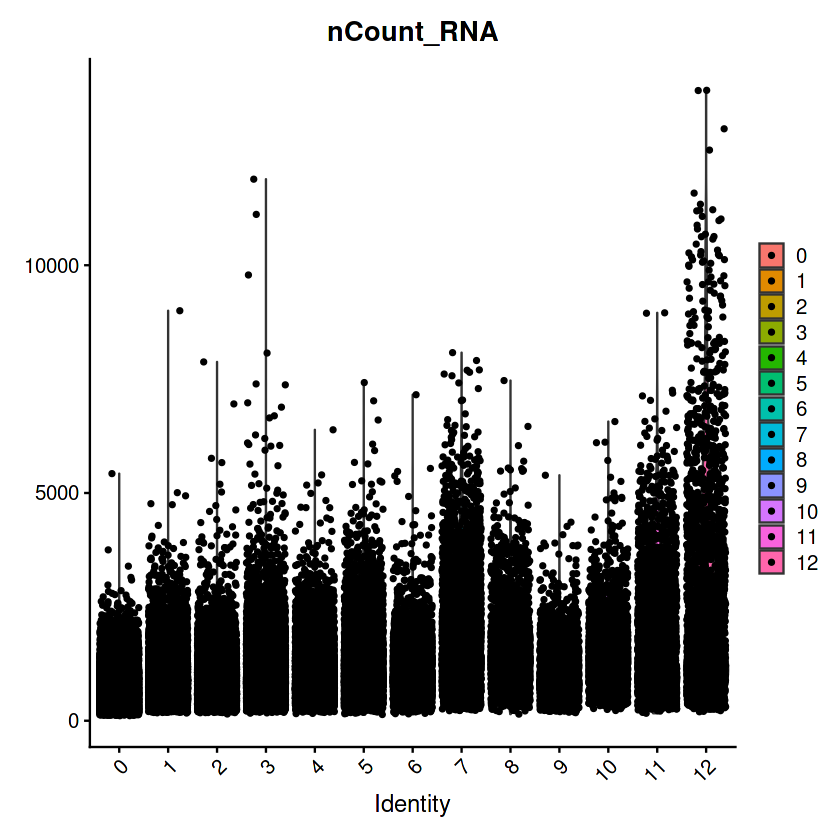

In [31]:
VlnPlot(anndata, 'scrublet.score')
VlnPlot(anndata, 'nCount_RNA')

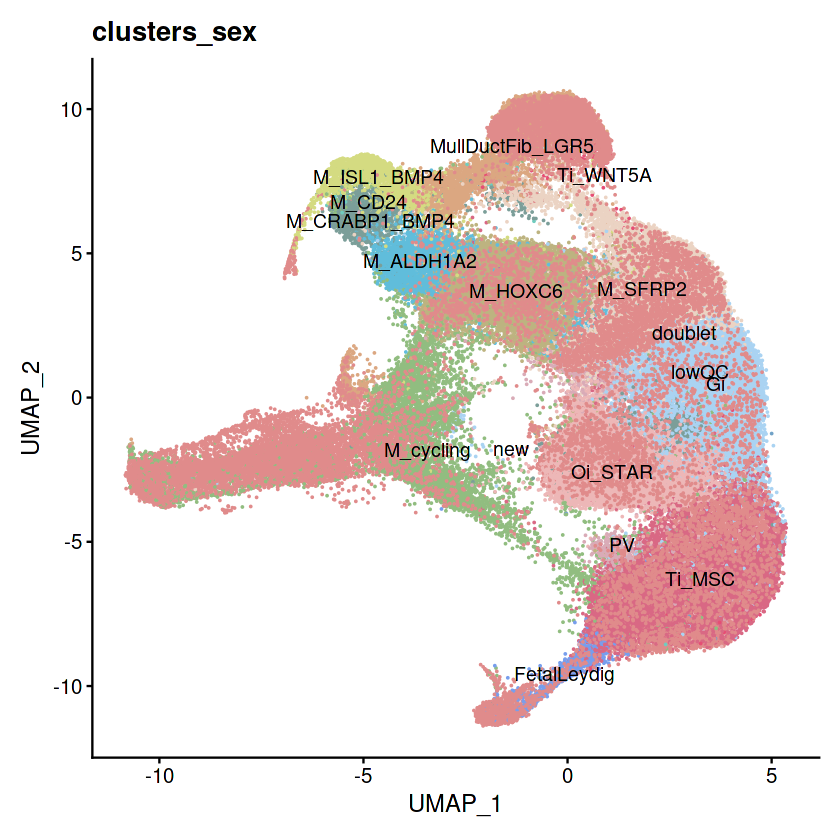

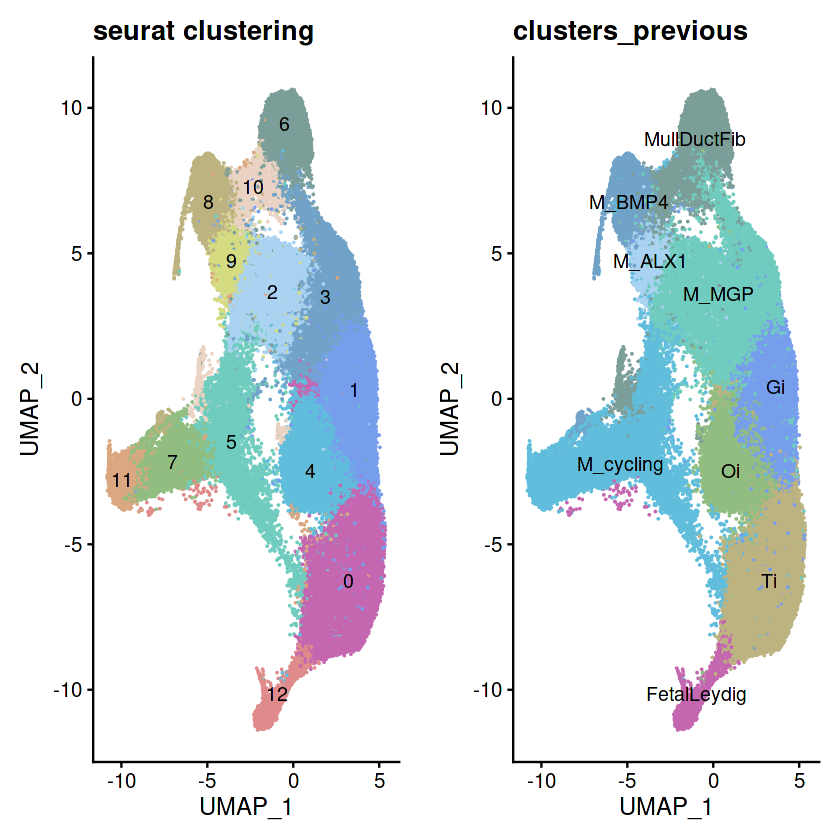

In [38]:
p1b+ NoLegend()
plot_grid(p1, p5+NoLegend(),ncol = 2)

In [61]:
cluster_names = c('Ti',#0
                  'Gi',
                  'M_MGP',
                  'M_MGP',
                  'Oi',
                  'M_cycling',#5
                  'M_MullDuct_LGR5',
                  'M_cycling',
                  'M_prog_ISL1',
                  'M_ALX1',
                  'M_MullDuct_AMHR2',#10
                  'M_cycling',
                  'FetalLeydig'
)


anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]

anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = c(
     'FetalLeydig','Ti',
                  'Oi',
                  'Gi',
                  'M_MullDuct_AMHR2',
                  'M_MullDuct_LGR5',
                  'M_MGP',
                  'M_ALX1',#10
                  'M_prog_ISL1',
                  'M_cycling'
))

Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

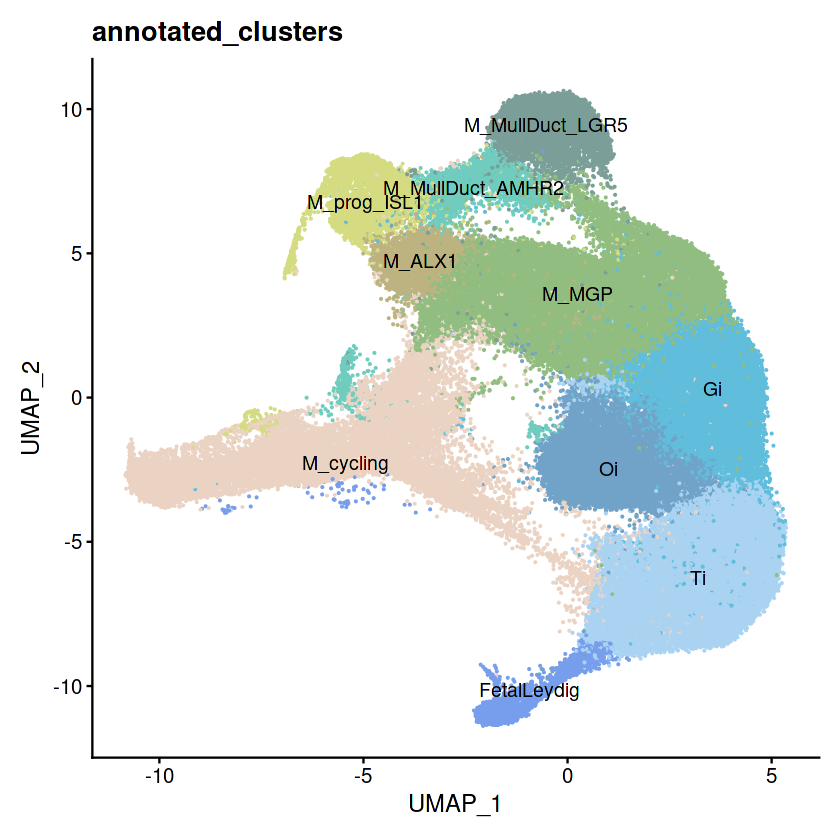

Saving 6.67 x 6.67 in image



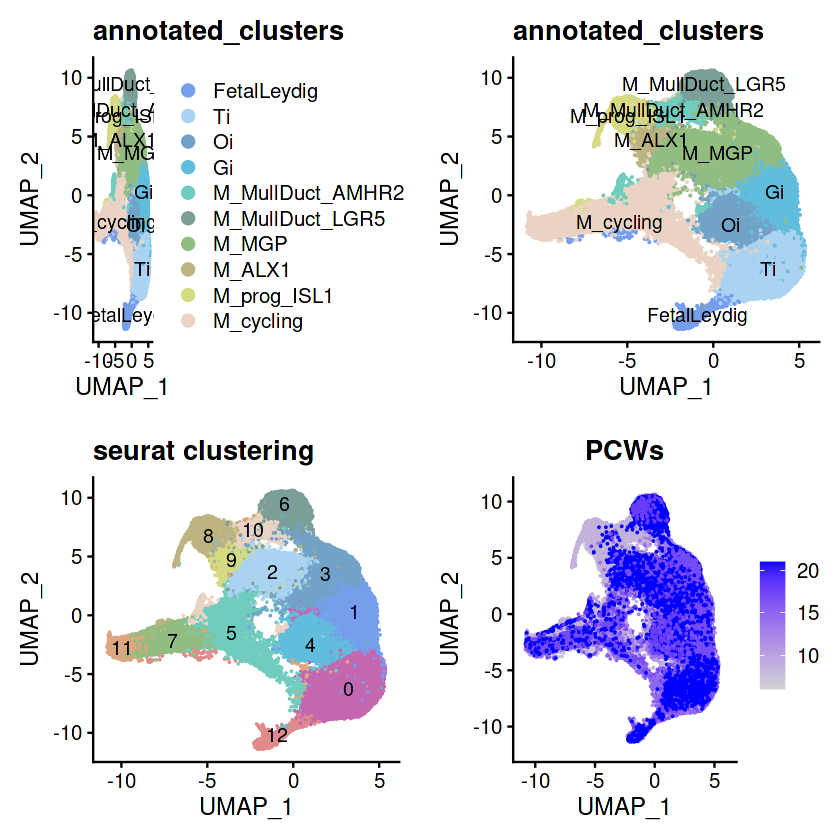

In [62]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()

plot_grid(p1b, p1b+ NoLegend(), p1, p3, ncol = 2)
ggsave(filename = paste0('figures-stromal/clean_umap_annotated.pdf'), dpi = 75)

Saving 6.67 x 6.67 in image



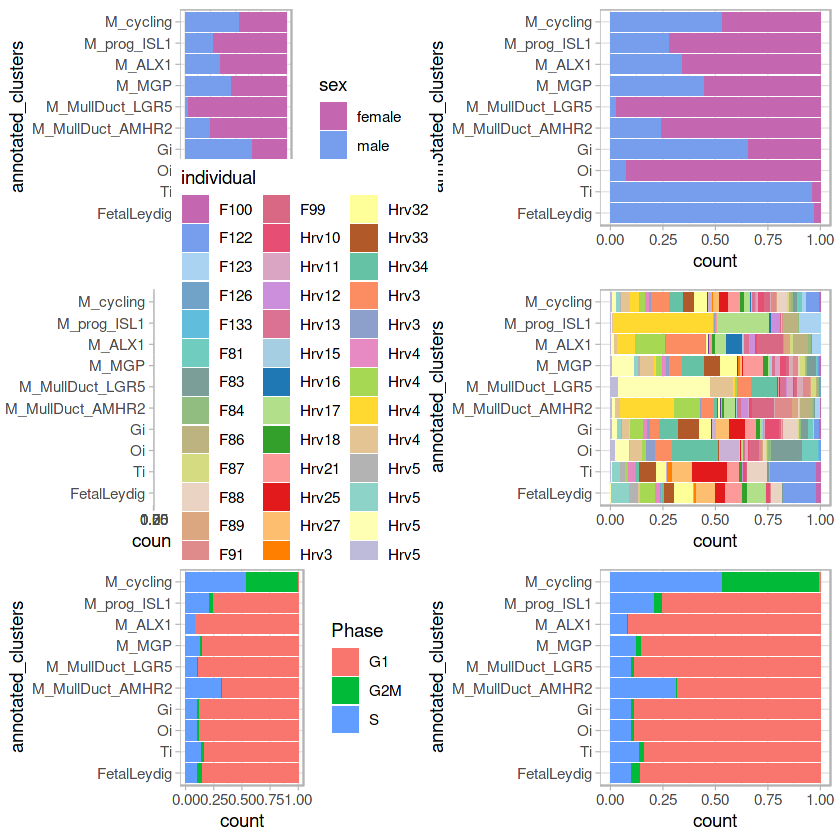

In [63]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()
plot_grid(b1, b1+NoLegend(), b2, b2+NoLegend(),  b3, b3+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-stromal/clean_barplots_annotated.pdf'), dpi = 75)

Saving 12 x 6.67 in image



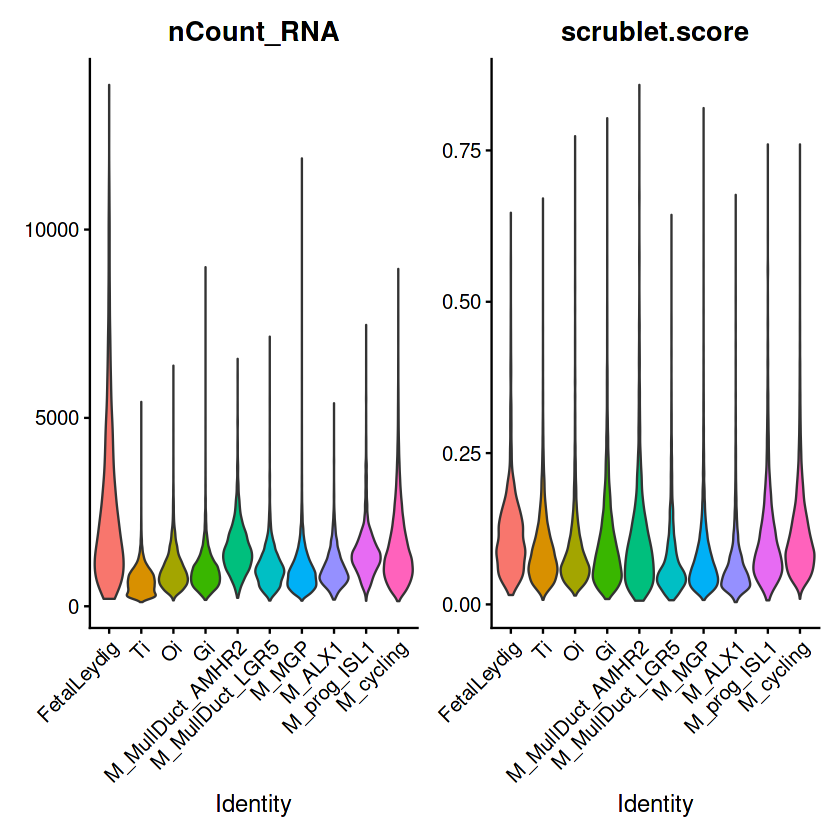

In [64]:
VlnPlot(anndata, c('nCount_RNA', 'scrublet.score'), pt.size = 0)
ggsave(filename = paste0('figures-stromal/clean_boxplots_annotated.pdf'), dpi = 75, width = 12)

### TF-IDF and Markers

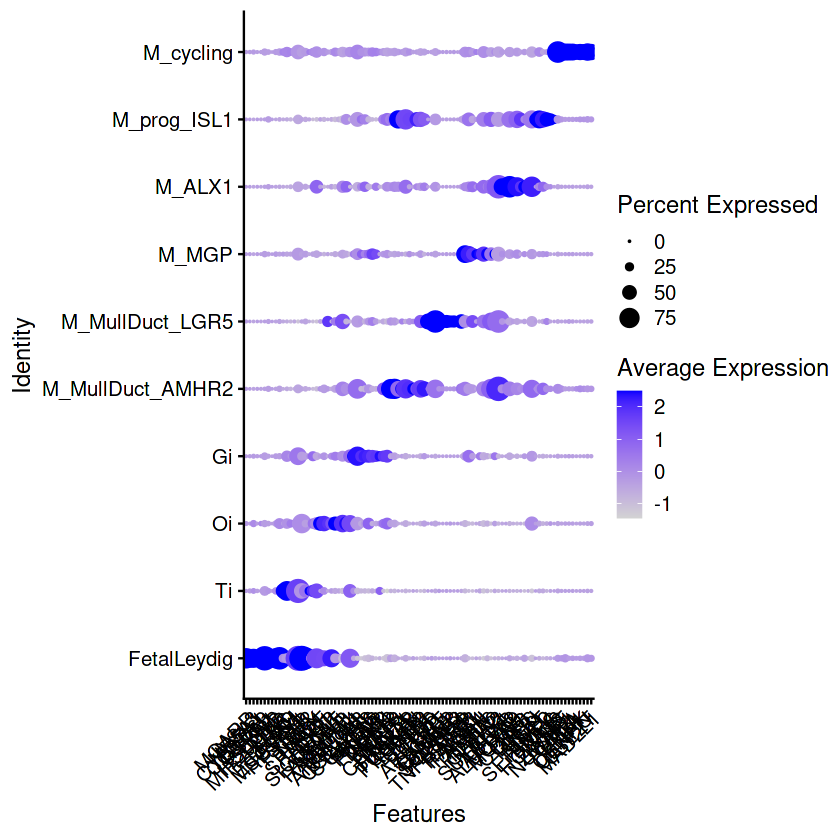

In [65]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
# write.csv(df_tfIDF, file = 'figures-epithelial/cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 10L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-stromal/clean_dotplot_TFIDF_annotated.pdf'), dpi = 75, height = 5, width = 30)

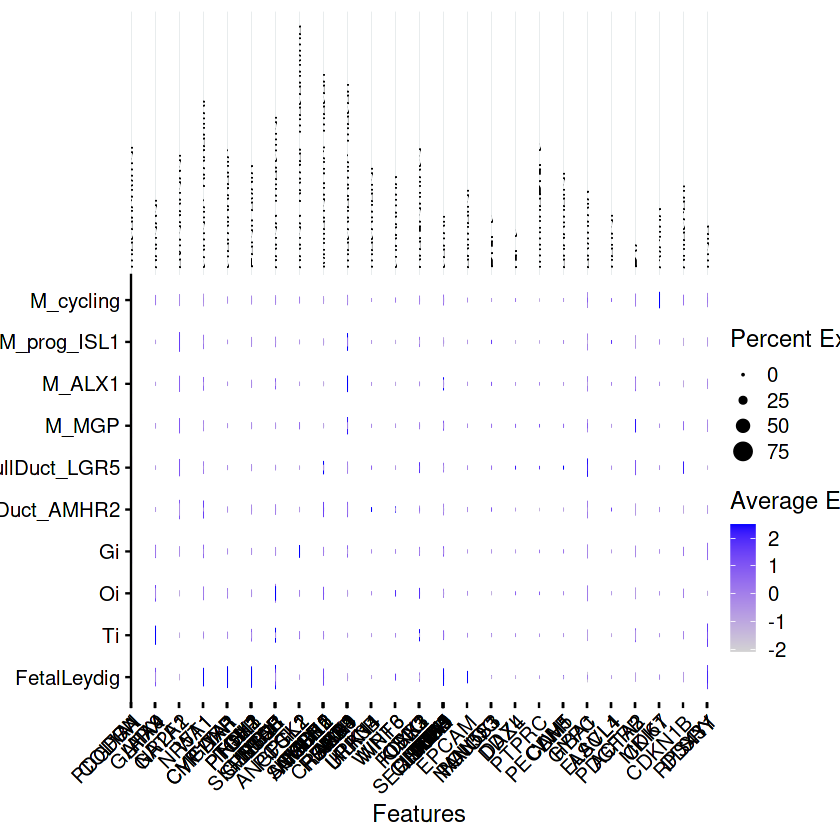

In [66]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-stromal/clean_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 30)

# Save

In [70]:
write.csv(anndata@meta.data, file = paste0('figures-stromal/clean_annotated.csv'), quote = F, row.names = T)
write.csv(anndata@meta.data, file = paste0('/nfs/team292/lg18/with_valentina/mesenchymal_annotated.csv'), quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/mesenchymal.rds')

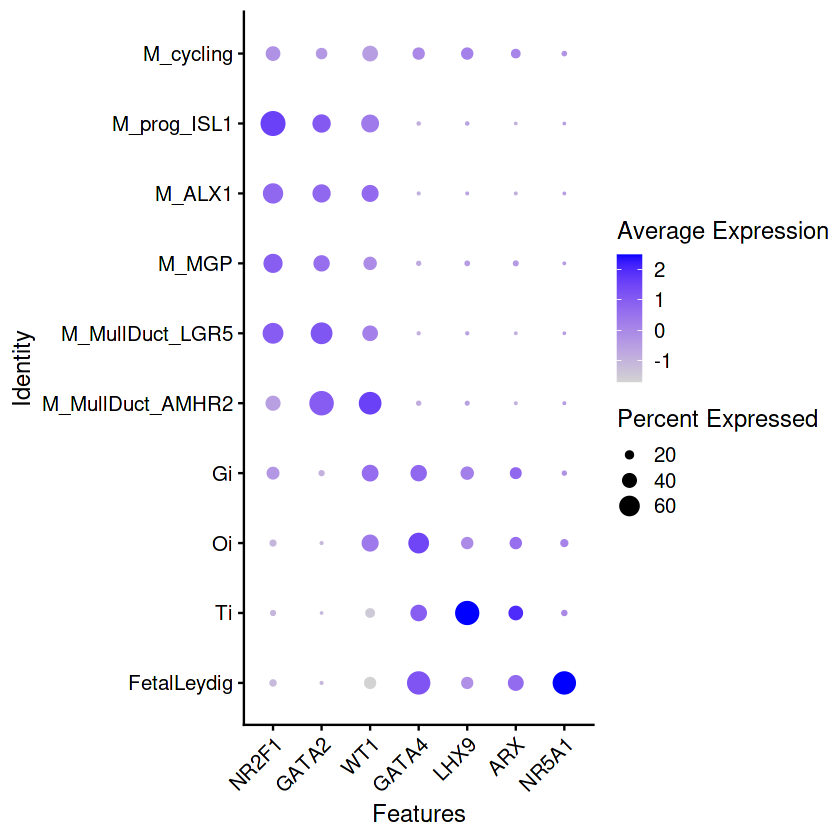

In [71]:
DotPlot(anndataO, features = c('NR2F1', 'GATA2', 'WT1',
                              'GATA4', 'LHX9', 'ARX', 'NR5A1') ) + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))

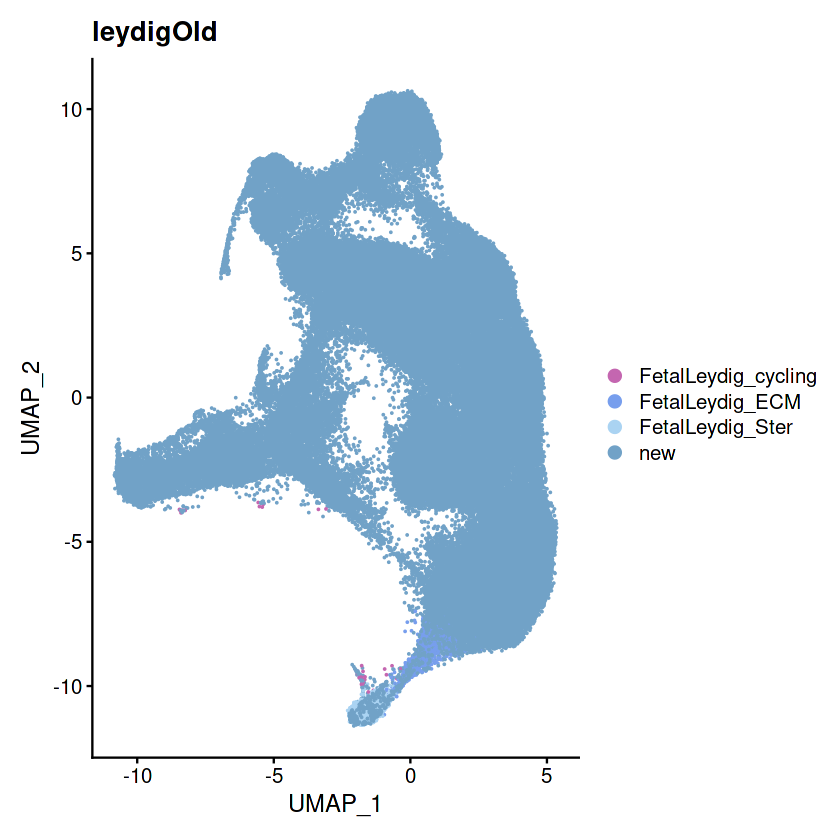

In [72]:
# fix metadata
# Add metadata
meta_f = read.csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/Leydig_annotated.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$leydigOld = 'new'

anndata@meta.data$leydigOld[ rownames(anndata@meta.data) %in% meta_f$X ] = 
meta_f$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_f$X], meta_f$X) ]
DimPlot(anndata, reduction = "umap", group.by = 'leydigOld', label = F, cols = colors) + ggtitle('leydigOld')